# Spark: DataFrame API

In [116]:
from pyspark.sql           import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types     import StringType
from pyspark.sql.types     import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import count
from pyspark.sql.functions import avg,col
from pyspark.sql.functions import sum as Fsum
import datetime
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName("Wrangling Data").getOrCreate()

In [3]:
path = "./sparkify_small_log.json"
user_log = spark.read.json(path)

In [4]:
user_log.take(2)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000')]

In [5]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
user_log.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [7]:
user_log.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|             10000|
|   mean|         4436.7511|
| stddev|2043.1281541827561|
|    min|                 9|
|    max|              7144|
+-------+------------------+



In [8]:
user_log.count()

10000

In [9]:
user_log.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [10]:
user_log.select(["userId","firstname","page","song"]).where(user_log.userId=="1046").collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstname='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstname='Kenneth'

## Calculating Statistics by Hour

In [11]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [12]:
user_log = user_log.withColumn("hour",get_hour(user_log.ts))

In [13]:
user_log.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='17')

In [15]:
songs_in_hour = user_log.filter(user_log.page == 'NextSong').groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [17]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  276|
|   1|  348|
|   2|  358|
|   3|  375|
|   4|  249|
|   5|  216|
|   6|  228|
|   7|  251|
|   8|  339|
|   9|  462|
|  10|  479|
|  11|  484|
|  12|  430|
|  13|  362|
|  14|  295|
|  15|  257|
|  16|  248|
|  17|  369|
|  18|  375|
|  19|  456|
+----+-----+
only showing top 20 rows



In [18]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

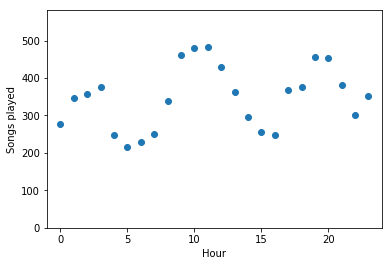

In [19]:
plt.scatter(songs_in_hour_pd["hour"],songs_in_hour_pd["count"])
plt.xlim(-1,24)
plt.ylim(0,1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

## Drop Rows with Missing Values

In [20]:
#check n/a value 
user_log_valid = user_log.dropna(how = "any",subset = ["userId","sessionId"])
user_log_valid.count()

10000

In [21]:
user_log.select("userId").dropDuplicates().sort("userId").count()

964

In [22]:
#Check empty UserId
user_log_valid = user_log_valid.filter(user_log_valid["userId"]!="")

In [23]:
user_log_valid.count()

9664

## Users downgrade their accounts

In [24]:
user_log_valid.filter("page == 'Submit Downgrade' ").show(1)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|   6|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [25]:
user_log.select(["userId","firstname","page","level","song"]).where(user_log.userId=="1138").collect()

[Row(userId='1138', firstname='Kelly', page='Home', level='paid', song=None),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Everybody Everybody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Gears'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Use Somebody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel"),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Fourteen Wives'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love On The Rocks'),
 Row(userId='1138', f

In [26]:
flag_downgrade_event = udf(lambda x: 1 if x=="Submit Downgrade" else 0, IntegerType())

In [27]:
user_log_valid = user_log_valid.withColumn("downgraded",flag_downgrade_event("page"))

In [28]:
user_log_valid.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='17', downgraded=0)

In [29]:
from pyspark.sql import Window

In [31]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding,0)

In [84]:
user_log_valid = user_log_valid.withColumn("phase",Fsum("downgraded").over(windowval))

In [89]:
user_log_valid.select(["userId","firstname","ts","page","level","phase"]).where(user_log.userId =="1138").sort("ts").collect()

[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513731182284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firs

## Which page did user id "" (empty string) NOT visit

In [101]:
blank_pages = user_log.select("page").where(user_log.userId == "").dropDuplicates()
all_pages = user_log.select("page").dropDuplicates()

for row in set(all_pages.collect()) - set(blank_pages.collect()):
    print(row.page)

NextSong
Submit Upgrade
Logout
Settings
Submit Downgrade
Upgrade
Downgrade
Save Settings
Error


## How many female users do we have in the data set:

In [102]:
user_log.filter(user_log.gender=='F').select("userId").dropDuplicates().count()

462

## How many songs were played from the most played artist

In [107]:
user_log_valid.dropna().groupBy("artist").agg({'song':'count'})\
            .withColumnRenamed('count(song)','Songcount').sort(desc("Songcount")).show(1)

+--------+---------+
|  artist|Songcount|
+--------+---------+
|Coldplay|       83|
+--------+---------+
only showing top 1 row



## How many songs do users listen to on average between visiting our home page

In [108]:
func = udf(lambda ishome: int(ishome == 'Home'),IntegerType())

In [110]:
windowSpec = Window.partitionBy("userId").orderBy(desc('ts'))\
            .rangeBetween(Window.unboundedPreceding,0)

In [112]:
cumul_sum = user_log.filter( (user_log.page == 'NextSong') | (user_log.page == 'Home')) \
            .select('userId','page','ts')\
            .withColumn('homevisit',func(col('page')))\
            .withColumn('period',Fsum('homevisit').over(windowSpec))

In [113]:
cumul_sum.show()

+------+--------+-------------+---------+------+
|userId|    page|           ts|homevisit|period|
+------+--------+-------------+---------+------+
|  1436|NextSong|1513783259284|        0|     0|
|  1436|NextSong|1513782858284|        0|     0|
|  2088|    Home|1513805972284|        1|     1|
|  2088|NextSong|1513805859284|        0|     1|
|  2088|NextSong|1513805494284|        0|     1|
|  2088|NextSong|1513805065284|        0|     1|
|  2088|NextSong|1513804786284|        0|     1|
|  2088|NextSong|1513804555284|        0|     1|
|  2088|NextSong|1513804196284|        0|     1|
|  2088|NextSong|1513803967284|        0|     1|
|  2088|NextSong|1513803820284|        0|     1|
|  2088|NextSong|1513803651284|        0|     1|
|  2088|NextSong|1513803413284|        0|     1|
|  2088|NextSong|1513803254284|        0|     1|
|  2088|NextSong|1513803057284|        0|     1|
|  2088|NextSong|1513802824284|        0|     1|
|  2162|NextSong|1513781246284|        0|     0|
|  2162|NextSong|151

In [115]:
cumul_sum.filter((cumul_sum.page == 'NextSong'))\
    .groupBy('userId','period')\
    .agg({'period':'count'})\
    .agg({'count(period)':'avg'}).show()

+------------------+
|avg(count(period))|
+------------------+
| 6.898347107438017|
+------------------+

